In [159]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns

import pymc3 as pm
print(pm.__version__)
import patsy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3.4.1


In [160]:
# generate dataset
mu = np.array([50, 80, 100])
sd = np.array([3, 5, 10])

n_samples = np.array([100, 150, 100])
factor_levels = np.array(['A', 'B', 'C'])

data = pd.DataFrame(data={
    'y':np.concatenate(
        (np.random.normal(loc=mu[0], scale=sd[0], size=n_samples[0]), 
         np.random.normal(loc=mu[1], scale=sd[1], size=n_samples[1]), 
         np.random.normal(loc=mu[2], scale=sd[2], size=n_samples[2]))
    ),
    'x':np.repeat(factor_levels, n_samples)
})

data.x = pd.Categorical(data.x, ordered=False)
data.head()

,x,y
0,A,50.390288
1,A,50.486929
2,A,51.062127
3,A,54.777889
4,A,50.467691


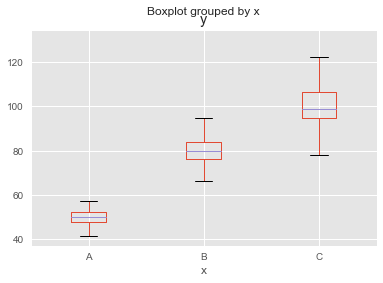

In [161]:
_ = data.boxplot(column='y', by='x')

In [162]:
## Treatment parametrization

In [163]:
# design matrix. Treatment (Dummy) Coding (see: https://onlinecourses.science.psu.edu/stat502/node/246)
_, X = patsy.dmatrices('y ~ 1 + x', data=data)
X

DesignMatrix with shape (350, 3)
  Intercept  x[T.B]  x[T.C]
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
  [320 rows omitted]
  Terms:
    'Intercept' (column 0)
    'x' (columns 1:3)
  (to view full data

The coding of the design matrix $\mathbf{X}$ are interpreted as:

$\beta_A = \mu_A$

$\beta_B = \mu_B - \mu_A$

$\beta_C = \mu_C - \mu_A$

$y = \beta_A + \beta_B \cdot x_B + \beta_C \cdot x_C$, where $x_B, x_C$ are 0 or 1 depending on the effect of interest

so, for example, the effect *B* is:

$y_{B} = \beta_A + \beta_B\cdot1$.

Similarly, for *C*:

$y_{C} = \beta_A + \beta_C\cdot1$

In [164]:
with pm.Model() as ANOVA_treatment_coding:
    
    beta = pm.Normal('beta', mu=0, sd=100, shape=(X.shape[1]))
    sd = pm.HalfCauchy('sd', beta=3, shape=(X.shape[1]))
    
    mu = pm.math.dot(np.asarray(X), beta)
    
    # the standard deviation is assumed to be different between groups. If I were to assume that instead the sd is the same
    # then I would see that the sampler would not converge properly
    y_likelihood = pm.Normal('y_likelihood', mu=mu, sd=sd[data.x.cat.codes], observed=data.y)
    
    trace = pm.sample(draws=3000, tune=1000, chains=4, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sd_log__, beta]


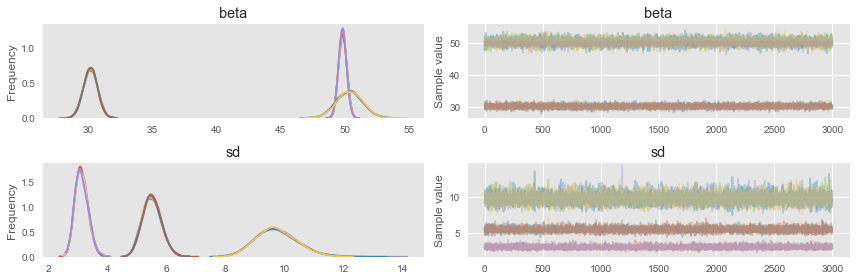

In [165]:
_ = pm.traceplot(trace)

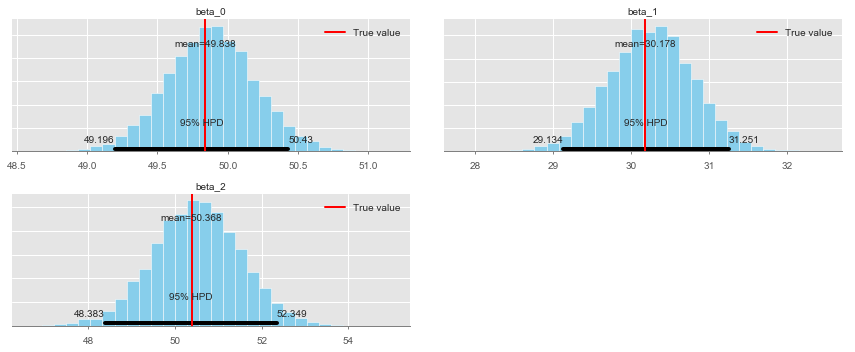

In [166]:
ax = pm.plot_posterior(trace, ['beta'])

data_grouped = data.groupby('x').mean()
ax[0].axvline(data_grouped.loc['A'].values, color='red', lw=2, label='True value')
ax[1].axvline(data_grouped.loc['B'].values - data_grouped.loc['A'].values, color='red', lw=2, label='True value')
ax[2].axvline(data_grouped.loc['C'].values - data_grouped.loc['A'].values, color='red', lw=2, label='True value')

ax[0].legend()
ax[1].legend()
ax[2].legend();

In [167]:
with ANOVA_treatment_coding:
    ppc = pm.sample_ppc(trace, samples=250)

100%|█████████████████████| 250/250 [00:00<00:00, 1774.05it/s]


In [168]:
ppc['y_likelihood'].shape

(250, 350)

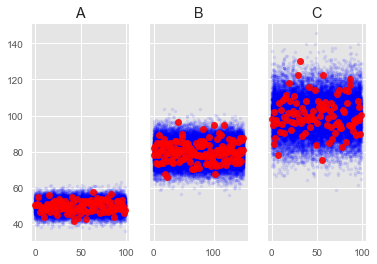

In [169]:
fig, ax = plt.subplots(1, len(data.x.unique()), sharey=True)

for i, x in enumerate(data.x.unique()):
    ax[i].plot(ppc['y_likelihood'].T[data.x==x], '.', alpha=0.1, color='blue')
    ax[i].plot(data.y[data.x==x].values, 'o', alpha=0.9, color='red')
    ax[i].set_title(x)

The posterior check suggests that the model fits the data well

## Effects parametrization

In [170]:
# design matrix. ´Effects model´ . The intercept is the grand mean, whereas the slope is the deviations of the factors levels
_, X = patsy.dmatrices('y ~ 0 + C(x, Sum)', data=data)
X

DesignMatrix with shape (350, 3)
  C(x, Sum)[mean]  C(x, Sum)[S.A]  C(x, Sum)[S.B]
                1               1               0
                1               1               0
                1               1               0
                1               1               0
                1               1               0
                1               1               0
                1               1               0
                1               1               0
                1               1               0
                1               1               0
                1               1               0
                1               1               0
                1               1               0
                1               1               0
                1               1               0
                1               1               0
                1               1               0
                1               1               0
                1

In [ ]:
with pm.Model() as ANOVA_sum_coding:
    
    beta = pm.Normal('beta', mu=0, sd=100, shape=(X.shape[1]))
    sd = pm.HalfCauchy('sd', beta=5, shape=(X.shape[1]))
    
    mu = pm.math.dot(np.asarray(X), beta)
    
    # the standard deviation is assumed to be different between groups. If I were to assume that instead the sd is the same
    # then I would see that the ampler would not converge properly
    y_likelihood = pm.Normal('y_likelihood', mu=mu, sd=sd[data.x.cat.codes], observed=data.y)
    
    trace = pm.sample(draws=3000, tune=1000, chains=4, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sd_log__, beta]


In [ ]:
_ = pm.traceplot(trace)

In [ ]:
# add deviation of C
beta_3 = - trace['beta'][:, 1] - trace['beta'][:, 2]
trace.add_values({'beta_3':beta_3})

In [ ]:
print('Grand mean = {}'.format(data.groupby(by='x').mean().mean().values))
print('Levels mean = ')
print(data.groupby(by='x').mean())

ax = pm.plot_posterior(trace, ['beta', 'beta_3'])

ax[0].axvline(data_grouped.mean().values, color='red', lw=2, label='True value')
ax[1].axvline(data_grouped.loc['A'].values - data_grouped.mean().values , color='red', lw=2, label='True value')
ax[2].axvline(data_grouped.loc['B'].values - data_grouped.mean().values, color='red', lw=2, label='True value')
ax[3].axvline(data_grouped.loc['C'].values - data_grouped.mean().values, color='red', lw=2, label='True value')

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend();

In [ ]:
with ANOVA_sum_coding:
    ppc = pm.sample_ppc(trace, samples=250)

In [ ]:
fig, ax = plt.subplots(1, len(data.x.unique()), sharey=True)

for i, x in enumerate(data.x.unique()):
    ax[i].plot(ppc['y_likelihood'].T[data.x==x], '.', alpha=0.1, color='blue')
    ax[i].plot(data.y[data.x==x].values, 'o', alpha=0.9, color='red')
    ax[i].set_title(x)

The posterior check suggests that the model fits the data well